In [1]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from gurobipy import *

# Enable high resolution plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Read the provided data via `pandas/geopandas`.  
Remove duplicates (by column 'plz') from `zuordnung_plz_ort.csv`. Make sure that all data frames contain the same number of rows.  
Append the state names to both the 'shape' and 'centroid' data frames.  
Reference: [read_file](https://geopandas.org/reference/geopandas.read_file.html), [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [drop_duplicates](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html), [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html)

In [2]:
def getPolititcalDistrictData(shp_file_centeroid, shp_file, csv_zuordnung):

    df_PLZ_BL = getDF_CSVZuordnung(csv_zuordnung)
    drop = list(df_PLZ_BL['plz'])

    df_Border = getDF_SHPFile(shp_file, drop)
    df_Center = getDF_SHPFileCenteroid(shp_file_centeroid, drop)

    if len(df_Border)  == len(df_Center) == len(df_PLZ_BL):
        df_Border = df_Border.merge(df_PLZ_BL[['bundesland', 'plz']], left_on = 'plz', right_on = 'plz')
        df_Center = df_Center.merge(df_PLZ_BL[['bundesland', 'plz']], left_on = 'plz', right_on = 'plz')

        return df_Border, df_Center

    else:
        print("Rows of dataframes are not matching.")


def getDF_SHPFileCenteroid(path, drop):
    df = gpd.read_file(path)
    df.drop(df[~df['plz'].str.contains('|'.join(str(x) for x in drop))].index, axis=0, inplace=True)
    df.drop(['note'], axis=1, inplace = True)
    df['plz'] = df['plz'].astype(int)

    return df

def getDF_SHPFile(path, drop):
    df = gpd.read_file(path)
    df.drop(df[~df['plz'].str.contains('|'.join(str(x) for x in drop))].index, axis=0, inplace=True)
    df.drop(['note'], axis=1, inplace = True)
    df['plz'] = df['plz'].astype(int)

    return df

def getDF_CSVZuordnung(path):
    df = pd.read_csv(path)
    df.drop_duplicates(subset ="plz", keep = 'first', inplace = True)

    # Comment to get all zip codes for germany
    df.drop(df[df['bundesland'] != "Saarland"].index, axis=0, inplace=True)

    return df



Create a contiguity graph $G$ as described on tutOR.

In [3]:
def createGraph(df_Border):
    G = nx.Graph()
    for index, row in df_Border.iterrows():
        G.add_node(row['plz'], population=row['einwohner'])
        G.add_edges_from((row['plz'], x) for x in row['neighbours'])

    return G


def findSharedBorders(df_Border):
    df_Border["neighbours"] = None

    for index, row in df_Border.iterrows():
        neighbors = df_Border[~df_Border.geometry.disjoint(row.geometry)].plz.tolist()
        neighbors = [ plz for plz in neighbors if row.plz != plz ]
        df_Border.at[index, "neighbours"] = neighbors

    return df_Border


Plot the map of Saarland. The following details need to be present in the picture:
* the borders of each postcode
* the centroids of each postcode
* the lines connecting the centroids of neighboring postcodes

Reference: [Mapping Tools](https://geopandas.org/mapping.html), [pyplot](https://matplotlib.org/tutorials/introductory/pyplot.html), [touches](https://geopandas.org/reference.html#geopandas.GeoSeries.touches)

In [4]:
def plotMap(df_Border, df_Center):
    df_Border = findSharedBorders(df_Border)
    G = createGraph(df_Border)
    df_Border.head()
    df_Border.plot()


shp_file_centeroid = "/Users/lukasbahr/POM/political_districting/data/plz-5stellig-centroid.shp"
shp_file  = "/Users/lukasbahr/POM/political_districting/data/plz-5stellig.shp"
csv_zuordnung  = "/Users/lukasbahr/POM/political_districting/data/zuordnung_plz_ort.csv"

df = getPolititcalDistrictData(shp_file_centeroid, shp_file, csv_zuordnung)
print(df)

(    einwohner    plz        qkm  \
0       11286  66111   1.894950   
1       23110  66113   8.863799   
2       18371  66115  30.957538   
3       14430  66117   9.324292   
4       14836  66119  10.341434   
..        ...    ...        ...   
64      11686  66802  34.032096   
65       6555  66806   8.387800   
66       9316  66809  22.503212   
67      19527  66822  64.203960   
68      16455  66839  58.627128   

                                             geometry bundesland  
0   POLYGON ((6.98259 49.24234, 6.99927 49.24285, ...   Saarland  
1   POLYGON ((6.99483 49.26179, 6.99284 49.25686, ...   Saarland  
2   POLYGON ((6.91801 49.24383, 6.92004 49.25297, ...   Saarland  
3   POLYGON ((6.93823 49.22245, 6.94436 49.23463, ...   Saarland  
4   POLYGON ((6.97161 49.20919, 6.97595 49.21174, ...   Saarland  
..                                                ...        ...  
64  POLYGON ((6.66009 49.28361, 6.66542 49.28502, ...   Saarland  
65  POLYGON ((6.79665 49.31986, 6.80424 49

Model the problem.
Upload the model to tutOR.

Split Saarland into 3 districts with the required district population being equal to 340000.

In [ ]:
k = 3
req_p = 340000

Use the `Gurobi` solution to plot the map of Saarland with each district colored in different color.

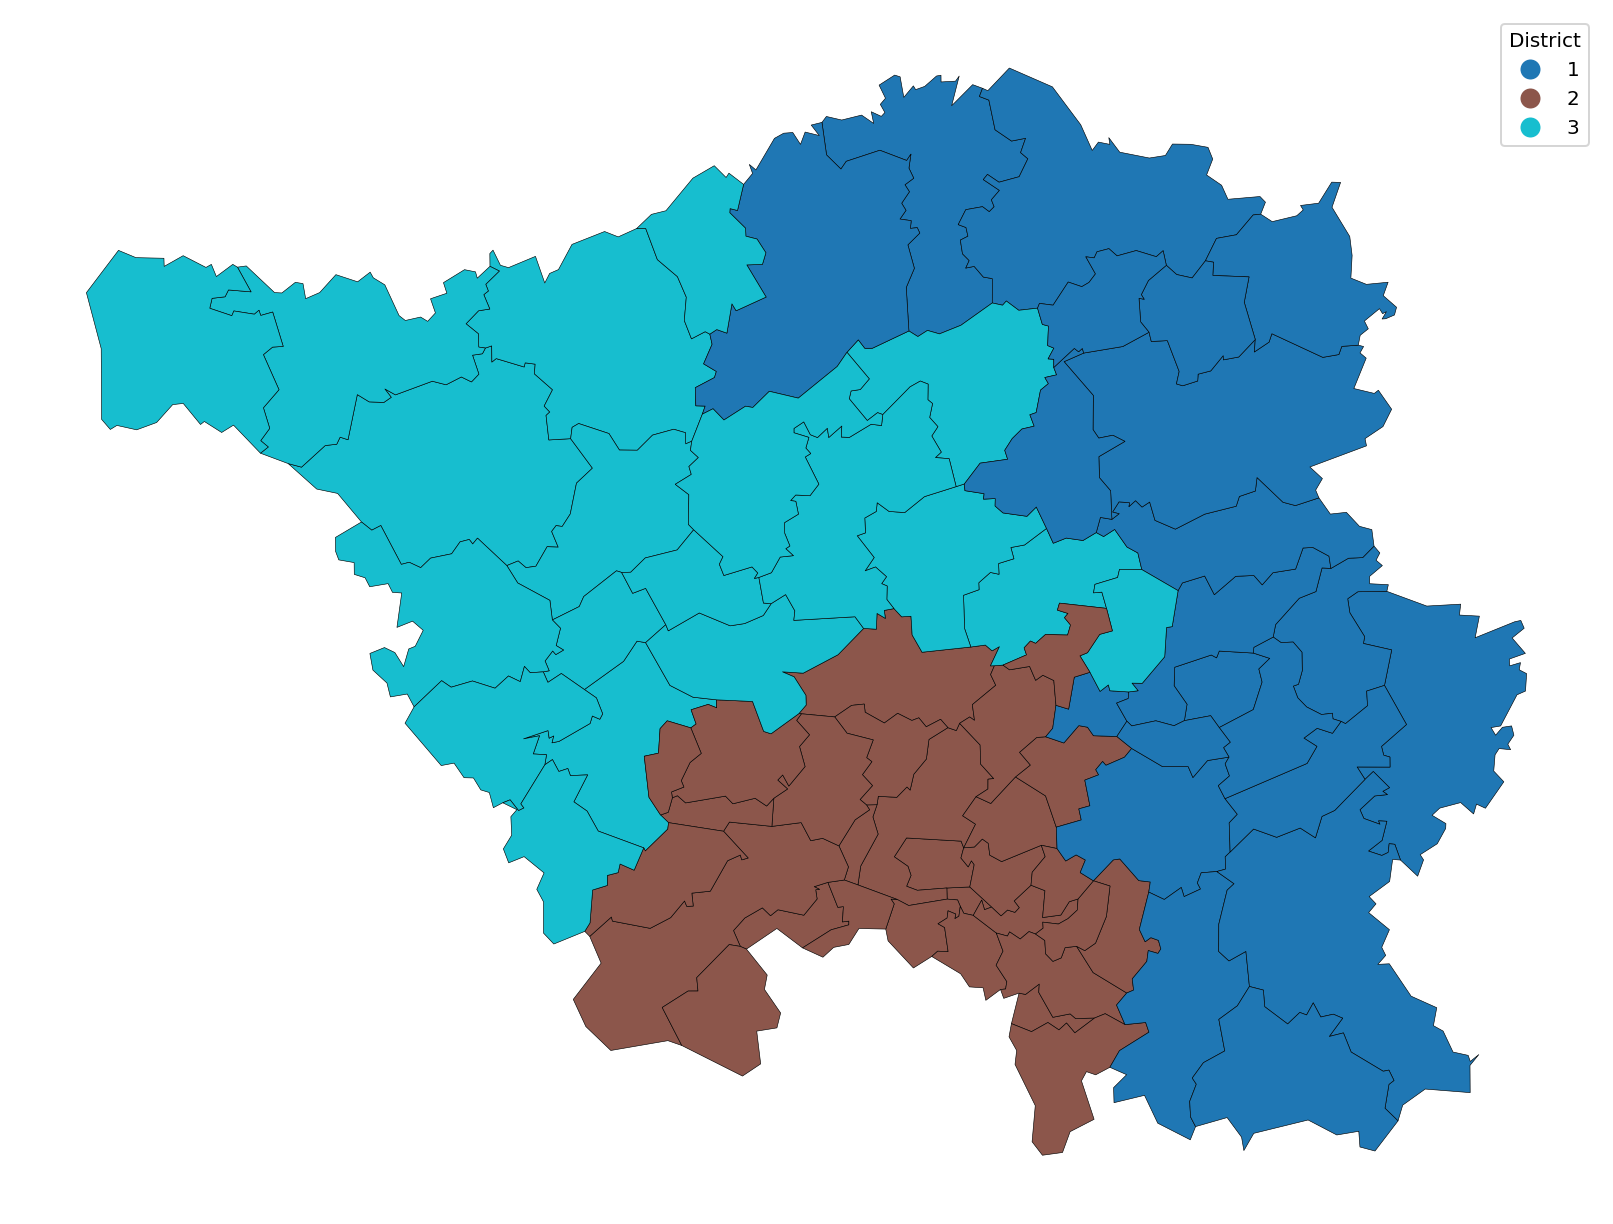

For each district:
* check whether the population constraint was satisfied (print the district's population)
* print the names of towns and villages assigned to it

Reference: [sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html)

District 1
Population: 324649
Towns and villages:
Friedrichsthal, Sankt Ingbert, Mandelbachtal, Homburg, Blieskastel, Bexbach, Gersheim, Kirkel, Neunkirchen, Ottweiler, Spiesen-Elversberg, Sankt Wendel, Nonnweiler, Nohfelden, Freisen, Namborn, Marpingen, Oberthal, Wadern

District 2
Population: 375820
Towns and villages:
Saarbrücken, Heusweiler, Kleinblittersdorf, Sulzbach/Saar, Quierschied, Riegelsberg, Völklingen, Püttlingen, Großrosseln, Bous, Merchweiler, Schwalbach, Wadgassen, Ensdorf/Saar

District 3
Population: 299977
Towns and villages:
Illingen, Eppelborn, Schiffweiler, Tholey, Merzig, Losheim am See, Mettlach, Beckingen, Perl, Weiskirchen, Saarlouis, Dillingen/Saar, Rehlingen-Siersburg, Saarwellingen, Wallerfangen, Überherrn, Nalbach, Lebach, Schmelz

